Importamos Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import subprocess
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2024-05-15 09:49:16.832160: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 09:49:17.539779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Usar la VRAM necesaria de la GPU

In [2]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")


Cantidad total de memoria VRAM en la GPU: 6.0 GB


2024-05-15 09:49:18.140151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 09:49:18.184123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 09:49:18.184448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Cargar la base de datos, en formato HDF5

In [3]:
df = pd.read_hdf('BD_Emotions_6.h5')

Revisión de los datos.

In [4]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[181, 181, 181, 181, 182, 182, 181, 182, 182,...","[[60, 68], [60, 74], [61, 80], [62, 86], [65, ...","[[27, 25, 33, 28, 19, 23, 33, 22, 23, 42, 79, ...",focused
1,"[[165, 165, 166, 165, 167, 166, 166, 166, 166,...","[[55, 59], [55, 65], [56, 72], [57, 78], [59, ...","[[165, 16, 8, 46, 13, 11, 8, 13, 32, 73, 93, 1...",focused
2,"[[162, 163, 162, 162, 163, 162, 162, 162, 162,...","[[56, 74], [56, 81], [58, 89], [59, 96], [62, ...","[[17, 18, 15, 23, 38, 67, 87, 96, 95, 102, 102...",focused
3,"[[167, 167, 167, 167, 169, 167, 167, 168, 168,...","[[59, 83], [59, 90], [59, 97], [60, 104], [61,...","[[173, 149, 16, 13, 13, 12, 31, 68, 91, 96, 10...",focused
4,"[[171, 169, 170, 168, 171, 172, 170, 170, 171,...","[[50, 67], [50, 74], [51, 81], [52, 88], [53, ...","[[171, 171, 170, 168, 52, 16, 8, 5, 8, 27, 72,...",focused


Retiramos cualquier dato de caracteristicas que pudiera dar un error o que no cumple con las caracteristicas deseadas. Vemos si tiene un formato Standard y ponemos que elimine todas las que no cumplan con ese Standard

In [5]:
print(df['Caracteristicas'][0].shape)

# Convertir la columna 'Hitos faciales válidos' en un array NumPy
puntos = np.array(df['Caracteristicas'].tolist())

# Verificar la forma de X
print(puntos.shape)

(72, 2)
(5023, 72, 2)


Pasamos las etiquetas a forma numerica, con lo cual caen en categorías numericas.

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Etiqueta'])

In [7]:
print(y)

[3 3 3 ... 0 0 0]


Verificación de los datos anteriores, donde vemos la forma de la categoría

In [8]:
print("Clases originales:", df['Etiqueta'].unique())
print("Clases codificadas:", label_encoder.classes_)


Clases originales: ['focused' 'relaxed' 'excited' 'engaged' 'interested' 'bored']
Clases codificadas: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']


Dividimos los datos para entrenar y para verificar la red MLP

In [9]:
X_train, X_test, y_train, y_test = train_test_split(puntos, y, test_size=0.3,random_state=42)

In [10]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_test)
clases_originales = df['Etiqueta'].unique()
print(y_val_one_hot)
print("Clases originales:", df['Etiqueta'].unique())

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
Clases originales: ['focused' 'relaxed' 'excited' 'engaged' 'interested' 'bored']


Creacion del modelo, la cantidad de capas es alta para intentar conseguir un accuracy alto, pero como los datos no son proporcionales la complejidad juega en su contra, por lo que ponerle menos capas ayuda a que tenga más accuracy

In [11]:
# Definir la entrada del modelo
inputs = Input(shape=(72, 2))

# Aplanar los datos de entrada
flatten = Flatten()(inputs)

# Capas densas

dense1 = Dense(600, activation='relu')(flatten)
dense2 = Dense(300, activation='relu')(dense1)
dense3 = Dense(150, activation='relu')(dense2)
dense4 = Dense(75, activation='relu')(dense3)
dense5 = Dense(37, activation='relu')(dense4)


# Capa de salida
outputs = Dense(len(label_encoder.classes_), activation='softmax')(dense5)

model = Model(inputs=inputs, outputs=outputs)

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2024-05-15 09:49:20.735832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 09:49:20.736163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 09:49:20.736356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
# Definir Early Stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

Entrenamos el modelo.

In [13]:
with tf.device('/device:GPU:0'):
    history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_split=0.1, 
                        #callbacks=[early_stopping]
                        )

best_loss, best_accuracy = model.evaluate(X_test, y_val_one_hot)
best_model = model
print(f'Best Loss: {best_loss}, Best Accuracy: {best_accuracy}')

Epoch 1/100


I0000 00:00:1715791762.117361   91945 service.cc:145] XLA service 0x7f73cc00eba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715791762.117382   91945 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-05-15 09:49:22.154146: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-15 09:49:22.325198: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3070 - loss: 11.1007

I0000 00:00:1715791764.189504   91945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.3098 - loss: 10.4044 - val_accuracy: 0.4290 - val_loss: 1.5126
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3733 - loss: 1.5102 - val_accuracy: 0.4062 - val_loss: 1.5587
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3738 - loss: 1.4229 - val_accuracy: 0.4432 - val_loss: 1.2844
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3982 - loss: 1.3568 - val_accuracy: 0.4148 - val_loss: 1.3181
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3865 - loss: 1.3373 - val_accuracy: 0.4062 - val_loss: 1.4857
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3670 - loss: 1.4131 - val_accuracy: 0.4205 - val_loss: 1.2770
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3933 - loss: 1.3267 - val_accuracy: 0.4062 - val_loss: 1.4552
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4027 - loss: 1.3463 - val_accuracy: 0.4347 - val_loss:

In [14]:
print(f'Best Loss: {best_loss}, Best Accuracy: {best_accuracy}')

Best Loss: 1.1603672504425049, Best Accuracy: 0.4591904580593109


Checamos como está distribuido los datos. Esto hay que tenerlo en cuenta, dado que esta base de datos solo servirá para Engaged, Excited o Bored. El resto tendrá problemas grandes en localizarlo

In [15]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


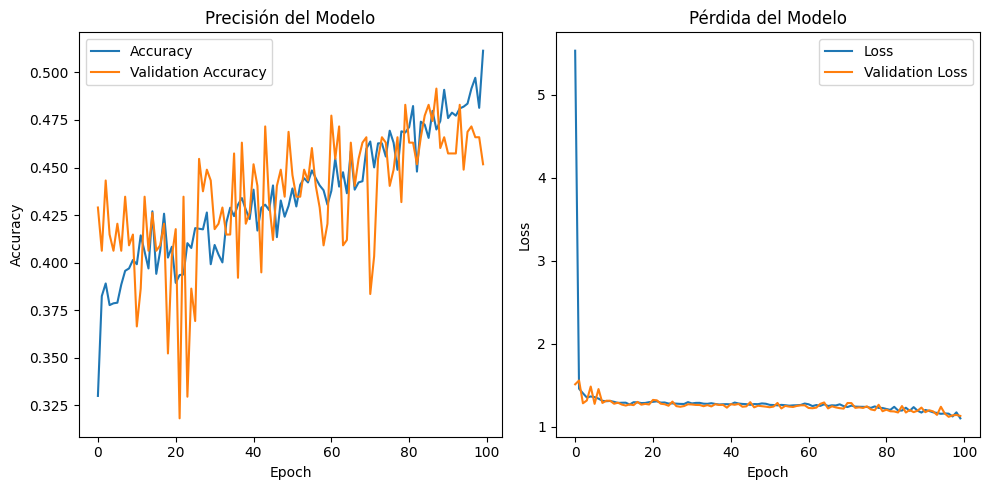

In [16]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
# 7. Evaluar el modelo en el conjunto de pruebas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


Precisión del modelo en el conjunto de pruebas: 0.45919044459190445


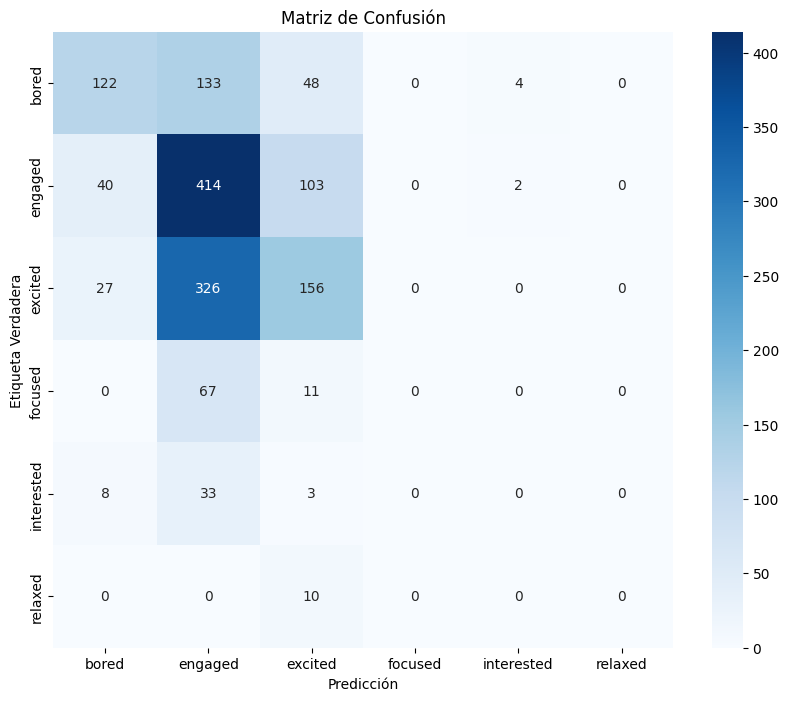

['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']


In [18]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred_classes)
print("Precisión del modelo en el conjunto de pruebas:", accuracy)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión de forma gráfica
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()
print(label_encoder.classes_)

Guardamos el modelo.

In [19]:
# Guardar el modelo
best_model.save('modelo_mlp_NoEstratificado.h5')